In [58]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax_tsv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

In [59]:
import kb_python.utils as kb_utils
import numpy as np
from scipy import stats
import anndata
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

### Alternative: Load data aligned to PalmDB using translated search kb without correcting for Seqwell barcode whitelist generated by kb (retaining all cells):

In [60]:
# Filepath to counts
X = f"{fastq_folder}/full_index_dna_cdna/virus_uncorrected/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{fastq_folder}/full_index_dna_cdna/virus_uncorrected/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{fastq_folder}/full_index_dna_cdna/virus_uncorrected/bustools_count/output.barcodes.txt" 

# Create AnnData object
palmdb_adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
palmdb_adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 31526093 × 99228

In [61]:
# Add sample barcodes to adata
sb_file = open(f"{fastq_folder}/full_index_dna_cdna/virus_uncorrected/bustools_count/output.barcodes.prefix.txt")
sample_barcodes = sb_file.read().splitlines() 
sb_file.close()

# Only use last 16 bases because sample barcode is always 16 bases in length
palmdb_adata.obs["sample_barcode"] = [bc[-16:] for bc in sample_barcodes]

In [62]:
# Create barcode to sample lookup
bc2sample_df = pd.DataFrame()

b_file = open(f"{fastq_folder}/full_index_dna_cdna/virus/matrix.sample.barcodes")
barcodes = b_file.read().splitlines() 
b_file.close()

s_file = open(f"{fastq_folder}/full_index_dna_cdna/virus/matrix.cells")
samples = s_file.read().splitlines() 
s_file.close()

bc2sample_df["sample_barcode"] = barcodes
bc2sample_df["srr"] = samples
bc2sample_df

,sample_barcode,srr
0,AAAAAAAAAAAAAAAA,SRR12698516
1,AAAAAAAAAAAAAAAC,SRR12698524
2,AAAAAAAAAAAAAAAG,SRR12698536
3,AAAAAAAAAAAAAAAT,SRR12698560
4,AAAAAAAAAAAAAACA,SRR12698542
...,...,...
101,AAAAAAAAAAAACGCC,SRR12698577
102,AAAAAAAAAAAACGCG,SRR12698582
103,AAAAAAAAAAAACGCT,SRR12698514
104,AAAAAAAAAAAACGGA,SRR12698553


In [63]:
palmdb_adata.obs["barcode"] = palmdb_adata.obs.index.values
palmdb_adata.obs = palmdb_adata.obs.merge(bc2sample_df, on="sample_barcode", how="left").set_index("barcode", drop=False)
palmdb_adata.obs

,sample_barcode,barcode,srr
barcode,,,
AAAAAAAAAAAA,AAAAAAAAAAAAAAAA,AAAAAAAAAAAA,SRR12698516
AAAAAAAAAAAC,AAAAAAAAAAAAAAAA,AAAAAAAAAAAC,SRR12698516
AAAAAAAAAAAT,AAAAAAAAAAAAAAAA,AAAAAAAAAAAT,SRR12698516
AAAAAAAAAACA,AAAAAAAAAAAAAAAA,AAAAAAAAAACA,SRR12698516
AAAAAAAAAAGC,AAAAAAAAAAAAAAAA,AAAAAAAAAAGC,SRR12698516
...,...,...,...
TTTTTTGTACTA,AAAAAAAAAAAACGGC,TTTTTTGTACTA,SRR12698550
TTTTTTGTCTGT,AAAAAAAAAAAACGGC,TTTTTTGTCTGT,SRR12698550
TTTTTTTAAGCA,AAAAAAAAAAAACGGC,TTTTTTTAAGCA,SRR12698550


### Add timepoints from SRR metadata:

In [64]:
srr_meta = pd.read_csv("/home/laura/projects/virus-watch/seqwell/ebola_PRJNA665227/SraRunTable.txt", sep=",")
# Only keep relevent data
srr_meta["mdck_spike_in"] = srr_meta["mdck_spike_in"].fillna(False).values
srr_meta = srr_meta[["Run", "donor_animal", "Experiment", "mdck_spike_in", "hours_post_innoculation", "day_post_infection"]]
srr_meta

,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
0,SRR12698499,NHP1,SRX9178097,False,4.0,NaN
1,SRR12698500,NHP1,SRX9178098,False,4.0,NaN
2,SRR12698501,NHP1,SRX9178099,False,4.0,NaN
3,SRR12698502,NHP1,SRX9178100,False,4.0,NaN
4,SRR12698503,NHP1,SRX9178101,False,4.0,NaN
...,...,...,...,...,...,...
101,SRR12698600,NHP10,SRX9178198,False,NaN,7.0
102,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
103,SRR12698602,NHP24,SRX9178200,False,NaN,6.0
104,SRR12698603,NHP08,SRX9178201,False,NaN,-4.0


In [65]:
palmdb_adata.obs = (
        palmdb_adata
        .obs.merge(srr_meta, left_on="srr", right_on="Run", how="left")
        .set_index("barcode", drop=False)
    )

palmdb_adata.obs

,sample_barcode,barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
barcode,,,,,,,,,
AAAAAAAAAAAA,AAAAAAAAAAAAAAAA,AAAAAAAAAAAA,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAAAAAAAAAC,AAAAAAAAAAAAAAAA,AAAAAAAAAAAC,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAAAAAAAAAT,AAAAAAAAAAAAAAAA,AAAAAAAAAAAT,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAAAAAAAACA,AAAAAAAAAAAAAAAA,AAAAAAAAAACA,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAAAAAAAAGC,AAAAAAAAAAAAAAAA,AAAAAAAAAAGC,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
...,...,...,...,...,...,...,...,...,...
TTTTTTGTACTA,AAAAAAAAAAAACGGC,TTTTTTGTACTA,SRR12698550,SRR12698550,NHP24,SRX9178148,True,NaN,6.0
TTTTTTGTCTGT,AAAAAAAAAAAACGGC,TTTTTTGTCTGT,SRR12698550,SRR12698550,NHP24,SRX9178148,True,NaN,6.0
TTTTTTTAAGCA,AAAAAAAAAAAACGGC,TTTTTTTAAGCA,SRR12698550,SRR12698550,NHP24,SRX9178148,True,NaN,6.0


Create clean dpi column:

In [66]:
# Join day_post_infection and hours_post_innoculation columns
palmdb_adata.obs["dpi"] = palmdb_adata.obs["day_post_infection"].fillna(palmdb_adata.obs["hours_post_innoculation"]).astype(int)

# Add h/d accession to denote hours/days 
palmdb_adata.obs["dpi_accessions"] = np.where(palmdb_adata.obs["hours_post_innoculation"].isna(), "d", "h")
palmdb_adata.obs["dpi_clean"] = palmdb_adata.obs["dpi"].astype(str) + palmdb_adata.obs["dpi_accessions"].astype(str)

palmdb_adata.obs

,sample_barcode,barcode,srr,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection,dpi,dpi_accessions,dpi_clean
barcode,,,,,,,,,,,,
AAAAAAAAAAAA,AAAAAAAAAAAAAAAA,AAAAAAAAAAAA,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN,4,h,4h
AAAAAAAAAAAC,AAAAAAAAAAAAAAAA,AAAAAAAAAAAC,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN,4,h,4h
AAAAAAAAAAAT,AAAAAAAAAAAAAAAA,AAAAAAAAAAAT,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN,4,h,4h
AAAAAAAAAACA,AAAAAAAAAAAAAAAA,AAAAAAAAAACA,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN,4,h,4h
AAAAAAAAAAGC,AAAAAAAAAAAAAAAA,AAAAAAAAAAGC,SRR12698516,SRR12698516,NHP2,SRX9178114,False,4.0,NaN,4,h,4h
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGTACTA,AAAAAAAAAAAACGGC,TTTTTTGTACTA,SRR12698550,SRR12698550,NHP24,SRX9178148,True,NaN,6.0,6,d,6d
TTTTTTGTCTGT,AAAAAAAAAAAACGGC,TTTTTTGTCTGT,SRR12698550,SRR12698550,NHP24,SRX9178148,True,NaN,6.0,6,d,6d
TTTTTTTAAGCA,AAAAAAAAAAAACGGC,TTTTTTTAAGCA,SRR12698550,SRR12698550,NHP24,SRX9178148,True,NaN,6.0,6,d,6d


In [67]:
# Merge 7d and 8d timepoints
new_tps = []
for tp in palmdb_adata.obs["dpi_clean"].values:
    if tp == "7d" or tp == "8d":
        new_tps.append("7d/8d")
    else:
        new_tps.append(tp)

palmdb_adata.obs["dpi_clean_merged"] = new_tps

___
### Correlation between between qPCR viral load and kb EBOV detection

In [68]:
phylogeny_data = pd.read_csv(u_tax_tsv)
phylogeny_data

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


In [69]:
# Raw viral load data provided by authors
viralload = pd.read_csv("/home/laura/projects/virus-watch/seqwell/ebola_PRJNA665227/viral_loads_fixid.tsv", sep="\t")

# Change naming of animal IDs to match naming in scseq data
viralload = viralload.replace("NHP01", "NHP1")
viralload = viralload.replace("NHP02", "NHP2")
viralload = viralload.set_index("Unnamed: 0")

viralload = viralload.rename(columns={'BL':0})
viralload.head()

,0,1,2,3,4,5,6,7,8
Unnamed: 0,,,,,,,,,
NHP1,UND,NaN,NaN,NaN,NaN,NaN,2.890000e+10,NaN,NaN
NHP2,UND,NaN,NaN,NaN,NaN,NaN,NaN,3.880000e+08,NaN
NHP03,UND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.110000e+09
NHP04,UND,NaN,NaN,NaN,NaN,NaN,NaN,1.460000e+09,NaN
NHP05,UND,NaN,NaN,NaN,NaN,112000000.0,NaN,NaN,NaN


In [70]:
viralload_log = viralload.replace('UND', 1)
viralload_log_unstack = viralload_log.unstack().reset_index()
viralload_log_unstack.columns = ['Day', 'Animal', 'log_viral_load']
viralload_log_unstack = viralload_log_unstack.dropna()
viralload_log_unstack['Day']=viralload_log_unstack['Day'].astype(int)

vl_perday_mean = viralload_log_unstack.groupby('Day')['log_viral_load'].median()
vl_perday_min = viralload_log_unstack.groupby('Day')['log_viral_load'].min()
vl_perday_max = viralload_log_unstack.groupby('Day')['log_viral_load'].max()


vl_day_sumary_stats = pd.concat([vl_perday_mean, vl_perday_min, vl_perday_max], axis=1)
vl_day_sumary_stats.columns = ['mean', 'min', 'max']
vl_day_sumary_stats

,mean,min,max
Day,,,
0,1.000000e+00,1.0,1.000000e+00
1,1.000000e+00,1.0,1.000000e+00
2,1.000000e+00,1.0,1.000000e+00
3,5.100000e+05,1980.0,6.560000e+06
4,6.050000e+07,2010000.0,3.700000e+08
5,3.505000e+08,760000.0,8.180000e+09
6,1.081000e+10,361000000.0,3.530000e+10
7,1.765000e+09,388000000.0,1.670000e+10
8,5.165000e+09,805000000.0,9.270000e+09


In [71]:
# Drop rows with samples not contained in scseq data
vl_day_sumary_stats = vl_day_sumary_stats.drop([1,2])

In [72]:
phylogeny_data[phylogeny_data["species"].str.contains("Zaire ebolavirus")]

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
409,u10,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
410,u103032,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
411,u1124,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
412,u11800,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
413,u12185,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
...,...,...,...,...,...,...,...,...,...
470,u52,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
471,u55137,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
472,u55996,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA
473,u9148,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus,-ssRNA


In [73]:
%%time
# Plot animals individually
samples = ["0d", "3d", "4d", "5d", "6d", "7d", "8d"]
labels = ["0", "3", "4", "5", "6", "7", "8"]

virus_ids = ['u10']

cidx = []
kb_counts = []
kb_counts_norm = []
vloads = []
for i, sample in enumerate(samples):
    for animal in viralload_log_unstack[viralload_log_unstack["Day"]==int(sample.split("d")[0])]["Animal"].values:
        if animal in np.unique(palmdb_adata.obs[palmdb_adata.obs["dpi_clean"] == sample]["donor_animal"].values):
            # Only take into account timpeoints/animals with at least 100k (unfiltered) cells
            num_cells = len(palmdb_adata.obs[(palmdb_adata.obs["dpi_clean"] == sample) & (palmdb_adata.obs["donor_animal"] == animal)])
            if num_cells > 100000:
                count = palmdb_adata[(palmdb_adata.obs["dpi_clean"] == sample) & (palmdb_adata.obs["donor_animal"] == animal), palmdb_adata.var.index.isin(virus_ids)].X.sum()
                kb_counts.append(count)
                kb_counts_norm.append(count / num_cells)

                vloads.append(viralload.replace('UND', 0).loc[animal].values[int(sample.split("d")[0])])
                cidx.append(i)

                print(sample, " ", animal, " ", count, " ", num_cells)

0d   NHP13   2.0   436656
0d   NHP14   0.0   556976
0d   NHP15   0.0   132690
0d   NHP16   1.0   180681
0d   NHP17   0.0   232620
0d   NHP18   0.0   208036
3d   NHP13   0.0   2861937
3d   NHP14   1.0   2289281
3d   NHP15   7.0   1066963
4d   NHP19   10.0   1280684
5d   NHP16   17.0   1889396
5d   NHP17   15.0   754775
5d   NHP18   0.0   1246547
6d   NHP11   21.0   1413000
6d   NHP22   166.0   2137809
6d   NHP23   47.0   1650555
6d   NHP24   21.0   2092940
7d   NHP10   7.0   1525890
CPU times: user 8min 33s, sys: 57.1 s, total: 9min 30s
Wall time: 9min 26s


/tmp/ipykernel_198978/757029466.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(labels)


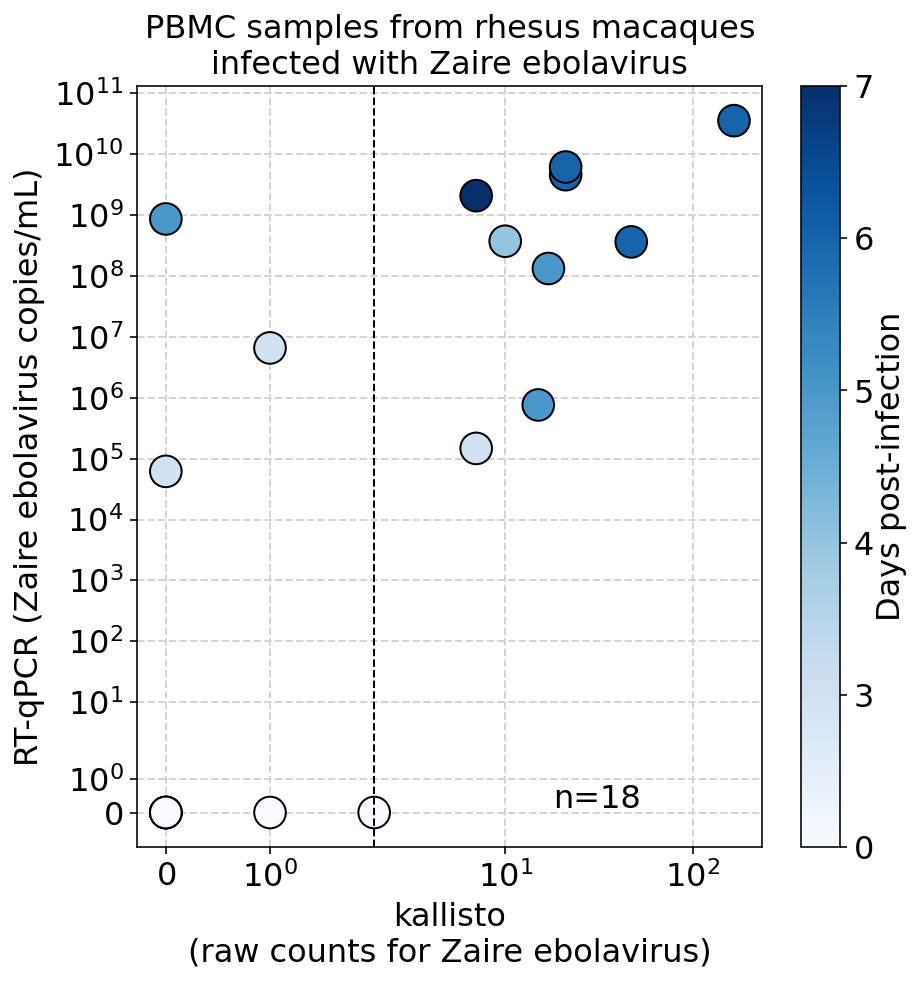

In [74]:
fig, ax = plt.subplots(figsize=(7,7))

fontsize=16
# norm = plt.Normalize(0, len(samples))
# cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", "red"])

# ax.scatter(kb_counts, vloads, c=cidx, cmap=cmap, norm=norm, edgecolors="black", s=250)
sc = ax.scatter(kb_counts, vloads, c=cidx, cmap="Blues", edgecolors="black", s=250, zorder=2)
# sc = ax.scatter(kb_counts, vloads, c=num_cells, cmap="Reds", edgecolors="black", s=250)

# # Plot min/max errorbars
# xerr = [np.array(kb_counts) - np.array(kb_counts_min), np.array(kb_counts_max) - np.array(kb_counts)]
# ax.errorbar(kb_counts, vloads, xerr=xerr, elinewidth=0.75, ecolor="black", zorder=1, ls="")

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_yticklabels(labels)
cbar.ax.set_ylabel("Days post-infection", fontsize=fontsize, labelpad=1.1)
            
ax.set_yscale("symlog")
ax.set_xscale("symlog")
ax.set_ylabel("RT-qPCR (Zaire ebolavirus copies/mL)", fontsize=fontsize)
ax.set_xlabel(
    "kallisto\n(raw counts for Zaire ebolavirus)",
    fontsize=fontsize,
)

# ax.set_xlim(right=1000)

ax.text(18, 0.15, f"n={len(kb_counts)}", fontsize=fontsize)

# Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="-", lw=1, zorder=1)

ax.axvline(2, ls="--", color="black", lw=1)
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"PBMC samples from rhesus macaques\ninfected with Zaire ebolavirus", fontsize=fontsize)
    
# plt.tight_layout()

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.savefig("figures/3.5_kb_vs_qPCR_scatter_cdna_dna.png", dpi=300, bbox_inches="tight")
            
fig.show()

In [75]:
%%time
# Plot means and min/max values across all animals
samples = ["0d", "3d", "4d", "5d", "6d", "7d", "8d"]
labels = ["0", "3", "4", "5", "6", "7", "8"]

virus_ids = phylogeny_data[phylogeny_data["species"].str.contains("Zaire ebolavirus")]["rep_ID"].values

cidx = []
kb_counts = []
kb_counts_min = []
kb_counts_max = []
vloads = []
for i, sample in enumerate(samples):
    kb_counts_per_animal = []
    vloads_per_animal = []
    for animal in viralload_log_unstack[viralload_log_unstack["Day"]==int(sample.split("d")[0])]["Animal"].values:
        if animal in np.unique(palmdb_adata.obs[palmdb_adata.obs["dpi_clean"] == sample]["donor_animal"].values):
            kb_counts_per_animal.append(palmdb_adata[(palmdb_adata.obs["dpi_clean"] == sample) & (palmdb_adata.obs["donor_animal"] == animal), palmdb_adata.var.index.isin(virus_ids)].X.sum())
            vloads_per_animal.append(viralload.replace('UND', 0).loc[animal].values[int(sample.split("d")[0])])
            
    kb_counts.append(np.mean(kb_counts_per_animal))
    kb_counts_min.append(np.min(kb_counts_per_animal))
    kb_counts_max.append(np.max(kb_counts_per_animal))
    vloads.append(np.mean(vloads_per_animal))
    cidx.append(i)

In [76]:
fig, ax = plt.subplots(figsize=(6,7))

fontsize=18
# norm = plt.Normalize(0, len(samples))
# cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", "red"])

# ax.scatter(kb_counts, vloads, c=cidx, cmap=cmap, norm=norm, edgecolors="black", s=250)
sc = ax.scatter(kb_counts[:-2], vloads[:-2], c=cidx[:-2], cmap="Reds", edgecolors="black", s=250, zorder=2)
# sc = ax.scatter(kb_counts, vloads, c=num_cells, cmap="Reds", edgecolors="black", s=250)

# Plot min/max errorbars
xerr = [np.array(kb_counts[:-2]) - np.array(kb_counts_min[:-2]), np.array(kb_counts_max[:-2]) - np.array(kb_counts[:-2])]
ax.errorbar(kb_counts[:-2], vloads[:-2], xerr=xerr, elinewidth=0.75, ecolor="black", zorder=1, ls="")

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_yticklabels(labels)
cbar.ax.set_ylabel("Days post-infection", fontsize=fontsize, labelpad=-10)
            
ax.set_yscale("symlog")
ax.set_xscale("symlog")
ax.set_ylabel("Zaire ebolavirus RT-qPCR (copies/mL)", fontsize=fontsize)
ax.set_xlabel(
    "kallisto\n(raw counts for Zaire ebolavirus)",
    fontsize=fontsize,
)

ax.text(18, 0.15, n="18", fontsize=fontsize)

# Add diagonal
# ax.plot([0, 1], [0, 1], transform=ax.transAxes, c="black", ls="-", lw=1, zorder=1)
        
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_title(f"Blood samples from rhesus macaques\ninfected with Zaire ebolavirus", fontsize=fontsize)
    
# plt.tight_layout()

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# plt.savefig("figures/3.5_kb_vs_qPCR_scatter_cdna_dna.png", dpi=300, bbox_inches="tight")
            
fig.show()

In [ ]:
samples = ["0d", "3d", "4d", "5d", "6d", "7d", "8d"]
labels = samples

virus_ids = phylogeny_data[phylogeny_data["species"].str.contains("Zaire ebolavirus")]["rep_ID"].values

kb_viralload = pd.DataFrame()

counts_mean = []
counts_min = []
counts_max = []
counts_std = []
for sample in samples:
    counts = []
    for animal in viralload_log_unstack[viralload_log_unstack["Day"]==int(sample.split("d")[0])]["Animal"].values:
        if animal in np.unique(palmdb_adata.obs[palmdb_adata.obs["dpi_clean"] == sample]["donor_animal"].values):
            counts.append(palmdb_adata[(palmdb_adata.obs["dpi_clean"] == sample) & (palmdb_adata.obs["donor_animal"] == animal), palmdb_adata.var.index.isin(virus_ids)].X.sum())
    if counts:
        counts_mean.append(np.mean(counts))
        counts_min.append(np.min(counts))
        counts_max.append(np.max(counts))
        counts_std.append(np.std(counts))
    else:
        counts_mean.append(0)
        counts_min.append(0)
        counts_max.append(0)
        counts_std.append(0)
    
counts_mean = np.array(counts_mean)
counts_min = np.array(counts_min)
counts_max = np.array(counts_max)

In [ ]:
fig, ax = plt.subplots(figsize=(6,7))
fontsize = 16

# Plot kb detected EBOV counts
color2 = "tab:red"
yerr2 = [counts_mean - counts_min, counts_max - counts_mean]
ax.errorbar(np.arange(len(samples)), counts_mean, yerr=yerr2, fmt='-o', ecolor=color2, markersize=6, elinewidth=0.75, color=color2)

# Plot qPCR copies
color = "#003049"
yerr = [vl_day_sumary_stats['mean'] - vl_day_sumary_stats['min'], vl_day_sumary_stats['max'] - vl_day_sumary_stats['mean']]
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(samples)), vl_day_sumary_stats['mean'], yerr=yerr, fmt='-o', ecolor=color, markersize=6, elinewidth=0.75, color=color)

ax.set_yscale("log")
ax2.set_yscale("log")

# # Set qPCR axis below
# ax.set_zorder(ax2.get_zorder()+1)
# ax.patch.set_visible(False)

ax2.set_ylabel('RNA copies / mL\n(qPCR)', color=color, fontsize=fontsize)
ax2.spines['right'].set_color(color)
ax2.tick_params(axis='y', colors=color)
ax.set_ylabel('Zaire Ebolavirus RdRP counts\n(scRNAseq + kallisto)', color=color2, fontsize=fontsize)
ax2.spines['left'].set_color(color2)
ax.tick_params(axis='y', colors=color2)
ax.set_xlabel('Days post infection', fontsize=fontsize)

# ax.set_xticks(np.arange(len(samples)), [tp.split("d")[0] for tp in samples], rotation=0, ha="center")
ax2.set_xticks(np.arange(len(samples)), [tp.split("d")[0] for tp in samples], rotation=0, ha="center")
        
ax.tick_params(axis="both", labelsize=fontsize)
ax2.tick_params(axis="both", labelsize=fontsize)

# ax.xaxis.grid(True, which="both", color="lightgray")
# ax.set_axisbelow(True)

# ax.set_title("Mean copies/counts", fontsize=fontsize+2)

# # Add bargrid
# x_width=1
# ylim = [-.05*10.,10.9]
# for i in range(7):
#     if (i % 2)==0:
#         ax2.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=ylim[1], facecolor='gray', alpha=0.1)

ax.xaxis.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

plt.minorticks_off()

plt.savefig("figures/3.4_qPCR_vs_kb_full_index.png", dpi=300, bbox_inches="tight")

fig.show()

Note: RNA copies are median while RdRP counts are mean. Min max values are between animals, so for RNA copies on timepoints where data from only one animal was available, there are no min max values.

In [ ]:
# fig, ax = plt.subplots(figsize=(7,7))
# fontsize = 16

# # Plot kb detected EBOV counts
# color2 = 'tab:red'
# yerr2 = [counts_mean - counts_min, counts_max - counts_mean]
# ax.errorbar(np.arange(len(samples)), counts_mean, yerr=yerr2, fmt='-o', ecolor=color2, markersize=6, elinewidth=0.75, color=color2)

# # Plot qPCR copies
# color = 'cornflowerblue'
# yerr = [vl_day_sumary_stats['mean'] - vl_day_sumary_stats['min'], vl_day_sumary_stats['max'] - vl_day_sumary_stats['mean']]
# ax2 = ax.twinx()
# ax2.errorbar(np.arange(len(samples)), vl_day_sumary_stats['mean'], yerr=yerr, fmt='-o', ecolor=color, markersize=6, elinewidth=0.75, color=color)

# ax.set_yscale("log")
# ax2.set_yscale("log")

# ax2.set_ylabel('RNA copies / mL\n(qPCR)', color=color, fontsize=fontsize)
# ax2.spines['right'].set_color(color)
# ax2.tick_params(axis='y', colors=color)
# ax.set_ylabel('Zaire Ebolavirus RdRP counts\n(scRNAseq + Kallisto)', color=color2, fontsize=fontsize)
# ax2.spines['left'].set_color(color2)
# ax.tick_params(axis='y', colors=color2)
# ax.set_xlabel('Days post infection', fontsize=fontsize, color="white")

# ax.set_xticks(np.arange(len(samples)), [tp.split("d")[0] for tp in samples], rotation=0, ha="center")
        
# ax.tick_params(axis="both", labelsize=fontsize)
# ax2.tick_params(axis="both", labelsize=fontsize)

# # ax.xaxis.grid(True, which="both", color="lightgray")
# # ax.set_axisbelow(True)

# ax.set_title("Kallisto vs qPCR", fontsize=fontsize+2, color="white")

# # Add bargrid
# x_width=1
# ylim = [-.05*10.,10.9]
# for i in range(7):
#     if (i % 2)==0:
#         ax.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=ylim[1], facecolor='grey', alpha=0.3)
    

# ax2.spines['bottom'].set_color('white')
# ax2.spines['top'].set_color('white')
# ax.tick_params(axis='x', colors='white')

# plt.minorticks_off()

# plt.savefig("figures/3.4_qPCR_vs_kb_white.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()

___
# Correlation between virus expression and clinical outcome

In [ ]:
# Raw clinical scores provided by authors
clinical_data = pd.read_csv('/home/laura/projects/virus-watch/seqwell/ebola_PRJNA665227/clinical_scores_fixid.tsv', sep='\t', header=[0,1])
challenge_group = pd.Series(clinical_data.iloc[:, 0].values, index=clinical_data.iloc[:, 2].values)
clinical_data.index = clinical_data.iloc[:,2].values
clinical_data = clinical_data.iloc[:,3:]
clinical_data = clinical_data.replace('>9', 10).astype(float)
clinical_data.head()

In [ ]:
## Full data with all intermediate timepoints within a day
jitter = .1
time_shift = .3


clinical_data_unstack = clinical_data.unstack().reset_index().dropna()
clinical_data_unstack.columns = ['Day', 'Time', 'Animal', 'Clinical_Score']
clinical_data_unstack['Day'] = clinical_data_unstack['Day'].astype(float)
clinical_data_unstack['Day_Shift'] = clinical_data_unstack['Time'].replace({'Early':0, 'Middle':time_shift, 'Late':(time_shift*2)})
clinical_data_unstack['Pos'] = clinical_data_unstack['Day'] + clinical_data_unstack['Day_Shift']

## Per-day summary statistics
#perday_mean = clinical_data_unstack.groupby('Day')['Clinical_Score'].mean()
#perday_95 = clinical_data_unstack.groupby('Day')['Clinical_Score'].quantile(.95)
#perday_5 = clinical_data_unstack.groupby('Day')['Clinical_Score'].quantile(.05)

perday_mean = clinical_data_unstack.groupby('Day')['Clinical_Score'].mean()
perday_95 = clinical_data_unstack.groupby('Day')['Clinical_Score'].min()
perday_5 = clinical_data_unstack.groupby('Day')['Clinical_Score'].max()

# clinical_day_sumary_stats = pd.concat([perday_mean, perday_5, perday_95], axis=1)
# clinical_day_sumary_stats.columns = ['median', 'min', 'max']

In [ ]:
# # Drop rows with samples not contained in scseq data
# clinical_day_sumary_stats = clinical_day_sumary_stats.drop([1,2])
# clinical_day_sumary_stats

In [ ]:
clinical_temp = clinical_data_unstack[(clinical_data_unstack["Day"] != 1.0) & (clinical_data_unstack["Day"] != 2.0)]
perdayanimal_mean = clinical_temp.groupby(['Day', 'Animal'])['Clinical_Score'].mean()
perdayanimal_min = clinical_temp.groupby(['Day', 'Animal'])['Clinical_Score'].min()
perdayanimal_max = clinical_temp.groupby(['Day', 'Animal'])['Clinical_Score'].max()

In [ ]:
clinical_day_sumary_stats = pd.concat([perdayanimal_mean, perdayanimal_min, perdayanimal_max], axis=1)
clinical_day_sumary_stats.columns = ['median', 'min', 'max']

In [ ]:
clinical_day_sumary_stats = clinical_day_sumary_stats.reset_index()
clinical_day_sumary_stats = clinical_day_sumary_stats.replace("NHP01", "NHP1")
clinical_day_sumary_stats = clinical_day_sumary_stats.replace("NHP02", "NHP2")

In [ ]:
clinical_day_sumary_stats[clinical_day_sumary_stats["Animal"]=="NHP12"]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for animal in clinical_day_sumary_stats["Animal"].unique():
    x = clinical_day_sumary_stats[clinical_day_sumary_stats["Animal"]==animal]["Day"].values
    y = clinical_day_sumary_stats[clinical_day_sumary_stats["Animal"]==animal]["median"].values
    ax.plot(x, y, label=animal)
    
ax.legend()
    
fig.show()

In [ ]:
sample = "6d"
virus_ids = [
    "u10", 
    "u202260"
]

df_clin = pd.DataFrame()

clin_median = []
clin_min = []
clin_max = []
animals = []
for i, virus_id in enumerate(virus_ids):
    counts_total = []
    # counts_mean = []
    # counts_min = []
    # counts_max = []
    # counts_std = []
    
    for animal in clinical_day_sumary_stats[clinical_day_sumary_stats["Day"] == float(sample.split("d")[0])]["Animal"].unique():
        if animal in palmdb_adata.obs[palmdb_adata.obs["dpi_clean"] == sample]["donor_animal"].values.unique() and animal != "NHP08":  # Removing NHP08 due to <10 EBOV+ cells at 6d

            # Get mean, etc of cells with positive virus expression
            pos_count = palmdb_adata[(palmdb_adata.obs["dpi_clean"] == sample) & (palmdb_adata.obs["donor_animal"] == animal), palmdb_adata.var.index == virus_id].X.sum()
            
            counts_total.append(pos_count)
            # counts_mean.append(np.mean(pos_count))
            # counts_min.append(np.min(pos_count))
            # counts_max.append(np.max(pos_count))
            # counts_std.append(np.std(pos_count))

            if i == 0:
                # Get clinical score and animal ID
                clin_median.append(clinical_day_sumary_stats[(clinical_day_sumary_stats["Day"] == float(sample.split("d")[0])) & (clinical_day_sumary_stats["Animal"] == animal)]["median"].values[0])
                clin_min.append(clinical_day_sumary_stats[(clinical_day_sumary_stats["Day"] == float(sample.split("d")[0])) & (clinical_day_sumary_stats["Animal"] == animal)]["min"].values[0])
                clin_max.append(clinical_day_sumary_stats[(clinical_day_sumary_stats["Day"] == float(sample.split("d")[0])) & (clinical_day_sumary_stats["Animal"] == animal)]["max"].values[0])
                
                animals.append(animal)
                
    df_clin[f"{virus_id}_total"] = counts_total
    # df_clin[f"{virus_id}_mean"] = counts_mean
    # df_clin[f"{virus_id}_min"] = counts_min
    # df_clin[f"{virus_id}_max"] = counts_max
    # df_clin[f"{virus_id}_std"] = counts_std
    
df_clin[f"clin_median"] = clin_median
df_clin[f"clin_min"] = clin_min
df_clin[f"clin_max"] = clin_max

df_clin[f"animals"] = animals

df_clin

In [ ]:
colors = ["tab:red", "grey", "black", "green"]
clin_color = "tab:blue"
ebov_color = colors[0]

fig, ax = plt.subplots(figsize=(10, 7))
markersize = 7
jitter = 0.03
elinewidth = 0.5
fontsize = 16

# Plot virus counts
# ebov_yerr = df_clin["Zaire ebolavirus_std"].values
# ax.errorbar(np.arange(len(df_clin["animals"].values)), df_clin["Zaire ebolavirus_mean"].values, yerr=ebov_yerr, fmt='o-', ecolor=ebov_color, markersize=markersize, elinewidth=elinewidth, color=ebov_color, label="EBOV", zorder=2)
ax.errorbar(np.arange(len(df_clin["animals"].values)), df_clin["u10_total"].values, fmt='o-', ecolor=ebov_color, markersize=markersize, elinewidth=elinewidth, color=ebov_color, label="EBOV", zorder=2)

# buhv_yerr = df_clin["Bubaline alphaherpesvirus 1_std"].values
# ax.errorbar(np.arange(len(df_clin["animals"].values))-jitter, df_clin["Bubaline alphaherpesvirus 1_mean"].values, yerr=buhv_yerr, fmt='o-', ecolor=colors[1], markersize=markersize, elinewidth=elinewidth, color=colors[1], label="BuHV-1", zorder=1)
ax.errorbar(np.arange(len(df_clin["animals"].values)), df_clin["u202260_total"].values, fmt='o-', ecolor=colors[1], markersize=markersize, elinewidth=elinewidth, color=colors[1], label="Wenzhou tombus-like", zorder=2)

# Plot clinical scores
ax2 = ax.twinx()
clin_yerr = [df_clin["clin_median"].values - df_clin["clin_min"].values, df_clin["clin_max"].values - df_clin["clin_median"].values]  
ax2.errorbar(np.arange(len(df_clin["animals"].values))+jitter, df_clin["clin_median"].values, yerr=clin_yerr, fmt='o-', ecolor=clin_color, markersize=markersize, elinewidth=elinewidth, color=clin_color)
        
ax.set_yscale("log")
# ax.set_ylim(bottom=1, top=100)
ax2.set_ylim(bottom=0)

# ax.set_ylabel('Mean UMI count in virus-positive cells', color=ebov_color, fontsize=fontsize)
ax.set_ylabel('# virus-positive cells', color=ebov_color, fontsize=fontsize)
ax2.spines['left'].set_color(ebov_color)
ax.tick_params(axis='y', colors=ebov_color)
ax2.set_ylabel('Clinical score', color=clin_color, fontsize=fontsize)
ax2.spines['right'].set_color(clin_color)
ax2.tick_params(axis='y', colors=clin_color)
ax.set_xlabel('Animal', fontsize=fontsize)

ax.set_xticks(np.arange(len(animals)), animals, rotation=0, ha="center")

ax.tick_params(axis="both", labelsize=fontsize)
ax2.tick_params(axis="both", labelsize=fontsize)

# ax.xaxis.grid(True, which="both", color="lightgray")
# ax.set_axisbelow(True)

leg = ax.legend(fontsize=fontsize)
for i, leg_txt in enumerate(leg.get_texts()):
    leg_txt.set_color(colors[i])

# # Add bargrid
# x_width=1
# ylim = [-.05*10.,10.9]
# for i in range(4):
#     if (i % 2)==0:
#         ax.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=ylim[1], facecolor='gray', alpha=0.1)

ax.set_title("Correlation between viral counts and clinical score\n6 days post infection", fontsize=fontsize+2)

# plt.minorticks_off()

plt.savefig("figures/3.4_clinical_score_vs_virus_d6.png", dpi=300, bbox_inches="tight")

fig.show()

# Using total # of pos cells right now, needs to be normalized to cell counts (= transforemd to fraction of pos cells)

In [ ]:
# colors = ["tab:red", "lightgrey"]
# clin_color = "cornflowerblue"
# ebov_color = colors[0]

# fig, ax = plt.subplots(figsize=(10, 7))
# markersize = 7
# jitter = 0.03
# elinewidth = 0.5
# label_color = "white"
# fontsize = 18

# # Plot virus counts
# # ebov_yerr = [df_clin["u55137_mean"].values - df_clin["u55137_min"].values, df_clin["u55137_max"].values - df_clin["u55137_mean"].values]  
# ebov_yerr = df_clin["u55137_std"].values
# ax.errorbar(np.arange(len(df_clin["animals"].values)), df_clin["u55137_mean"].values, yerr=ebov_yerr, fmt='o-', ecolor=ebov_color, markersize=markersize, elinewidth=elinewidth, color=ebov_color, label="EBOV", zorder=2)

# # buhv_yerr = [df_clin["u27694_mean"].values - df_clin["u27694_min"].values, df_clin["u27694_max"].values - df_clin["u27694_mean"].values]  
# buhv_yerr = df_clin["u27694_std"].values
# ax.errorbar(np.arange(len(df_clin["animals"].values))-jitter, df_clin["u27694_mean"].values, yerr=buhv_yerr, fmt='o-', ecolor=colors[1], markersize=markersize, elinewidth=elinewidth, color=colors[1], label="BuHV-1", zorder=1)

# # Plot clinical scores
# ax2 = ax.twinx()
# clin_yerr = [df_clin["clin_median"].values - df_clin["clin_min"].values, df_clin["clin_max"].values - df_clin["clin_median"].values]  
# ax2.errorbar(np.arange(len(df_clin["animals"].values))+jitter, df_clin["clin_median"].values, yerr=clin_yerr, fmt='o-', ecolor=clin_color, markersize=markersize, elinewidth=elinewidth, color=clin_color)
        
# ax.set_yscale("log")
# ax.set_ylim(bottom=1, top=100)
# ax2.set_ylim(bottom=0)

# ax.set_ylabel('Mean UMI count in virus-positive cells', color=ebov_color, fontsize=fontsize)
# ax2.spines['left'].set_color(ebov_color)
# ax.tick_params(axis='y', colors=ebov_color)
# ax2.set_ylabel('Clinical score', color=clin_color, fontsize=fontsize)
# ax2.spines['right'].set_color(clin_color)
# ax2.tick_params(axis='y', colors=clin_color)
# ax.set_xlabel('Animal', fontsize=fontsize, color=label_color)

# ax.set_xticks(np.arange(len(animals)), animals, rotation=0, ha="center")

# ax.tick_params(axis="both", labelsize=fontsize)
# ax2.tick_params(axis="both", labelsize=fontsize)

# # ax.xaxis.grid(True, which="both", color="lightgray")
# # ax.set_axisbelow(True)

# leg = ax.legend(fontsize=fontsize)
# leg.get_frame().set_alpha(0.2)
# for i, leg_txt in enumerate(leg.get_texts()):
#     leg_txt.set_color(colors[i])

# # # Add bargrid
# # x_width=1
# # ylim = [-.05*10.,10.9]
# # for i in range(4):
# #     if (i % 2)==0:
# #         ax.axvspan(i-(x_width/2), i+(x_width/2), ymin=ylim[0], ymax=ylim[1], facecolor='gray', alpha=0.1)

# ax.set_title("Viral counts and clinical score - 6 days post infection", fontsize=fontsize+2, color="white")

# # plt.minorticks_off()

# # ax.grid(True, which="both", color="grey")
# ax.set_axisbelow(True)

# ax2.spines['bottom'].set_color('white')
# ax2.spines['top'].set_color('white')
# ax.tick_params(axis='x', colors='white')

# plt.savefig("figures/3.4_clinical_score_vs_virus_d6_white.png", dpi=300, bbox_inches="tight", transparent = True)

# fig.show()